* * * * * * * * * R 
* * * . * . * * * * 
* * . . . . . . . . 
* * . # # # . . . . 
* * . . . # . . . . 
* # # . . # * * * . 
* * * * * * * O * . 
* * . . . . # O * . 
. . . . # # . * G * 
. . . . . . . . # * 


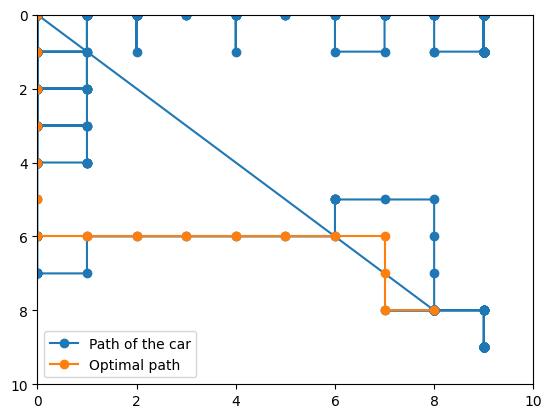

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq


class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class RobotCar:
    def __init__(self, x=0, y=0, radius=1):
        self.x = x
        self.y = y
        self.radius = radius

    def move(self, dx, dy, env):
        new_x = self.x + dx
        new_y = self.y + dy

        if 0 <= new_x < env.width and 0 <= new_y < env.height:
            self.x = new_x
            self.y = new_y

    def position(self):
        return (self.x, self.y)

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def set_radius(self, radius):
        self.radius = radius

    def get_radius(self):
        return self.radius

    def forward(self, distance):
        self.move(0, distance)

    def backward(self, distance):
        self.move(0, -distance)

    def turn_left(self, angle):
        # Assuming angle is in degrees
        self.x, self.y = self.y, -self.x

    def turn_right(self, angle):
        # Assuming angle is in degrees
        self.x, self.y = -self.y, self.x


class Environment:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.obstacles = set()
        self.goal = (8, 8)  # Define the goal location

    def add_obstacle(self, x, y):
        self.obstacles.add((x, y))

    def is_obstacle(self, x, y):
        return (x, y) in self.obstacles

    def is_goal(self, x, y):
        return (x, y) == self.goal

    def heuristic(self, position):
        """
        Calculates the heuristic value for the given position.
        Here, we use the Manhattan distance to the goal as the heuristic.

        Args:
            position: The current position.

        Returns:
            The heuristic value.
        """
        return abs(position[0] - self.goal[0]) + abs(position[1] - self.goal[1])

    def a_star(self, start, goal):
        """
        Implements A* algorithm to find the shortest path from start to goal.

        Args:
            start: Start position.
            goal: Goal position.

        Returns:
            The shortest path from start to goal.
        """
        def heuristic(position):
            return abs(position[0] - goal[0]) + abs(position[1] - goal[1])

        # Initialize the open and closed sets
        open_set = []
        closed_set = set()

        # Add the start node to the open set
        heapq.heappush(open_set, (0, start))

        # Initialize the cost and parent dictionaries
        cost = {start: 0}
        parent = {start: None}

        # Loop until the open set is empty
        while open_set:
            # Get the node with the lowest cost from the open set
            current_cost, current_node = heapq.heappop(open_set)

            # Check if the current node is the goal
            if current_node == goal:
                # Reconstruct the path from the parent dictionary
                path = []
                while current_node:
                    path.append(current_node)
                    current_node = parent[current_node]
                path.reverse()
                return path

            # Add the current node to the closed set
            closed_set.add(current_node)

            # Loop through the neighbors of the current node
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                neighbor = (current_node[0] + dx, current_node[1] + dy)

                # Skip neighbors that are obstacles or in the closed set
                if neighbor in self.obstacles or neighbor in closed_set:
                    continue

                # Calculate the tentative cost to the neighbor
                tentative_cost = cost[current_node] + 1

                # Update the cost and parent dictionaries if necessary
                if neighbor not in cost or tentative_cost < cost[neighbor]:
                    cost[neighbor] = tentative_cost
                    priority = tentative_cost + heuristic(neighbor)
                    heapq.heappush(open_set, (priority, neighbor))
                    parent[neighbor] = current_node

        # If the open set is empty and the goal was not reached, return None
        return None

    def display(self, robot_x, robot_y, trajectory, optimal_path):
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) == (robot_x, robot_y):
                    print("R", end=" ")  # Robot
                elif self.is_obstacle(x, y):
                    print("#", end=" ")  # Obstacle
                elif (x, y) == self.goal:
                    print("G", end=" ")  # Goal
                elif (x, y) in trajectory:
                    print("*", end=" ")  # Path of the car
                elif (x, y) in optimal_path:
                    print("O", end=" ")  # Optimal path
                else:
                    print(".", end=" ")  # Empty space
            print()


def q_learning(env, robot, num_episodes=1000, alpha=0.1, gamma=0.6, epsilon=0.1):

    input_dim = 2  # (x, y) coordinates
    output_dim = 4  # 4 actions (up, down, left, right)

    model = DQN(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=alpha)
    criterion = nn.MSELoss()

    trajectory = []

    for episode in range(num_episodes):
        state = torch.tensor([robot.x, robot.y], dtype=torch.float32)
        trajectory.append((robot.x, robot.y))

        while True:
            # Choose an action (epsilon-greedy)
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, output_dim - 1)  # Random action
            else:
                q_values = model(state)
                # Get the heuristic value from A* search
                heuristic_value = env.heuristic((robot.x, robot.y))
                # Combine the Q-value and heuristic value to select the action
                action = torch.argmax(q_values + gamma * torch.tensor(heuristic_value)).item()

            # Take the action and observe the next state and reward
            if action == 0:  # Up
                robot.move(0, 1, env)
            elif action == 1:  # Down
                robot.move(0, -1, env)
            elif action == 2:  # Left
                robot.move(-1, 0, env)
            elif action == 3:  # Right
                robot.move(1, 0, env)

            next_state = torch.tensor([robot.x, robot.y], dtype=torch.float32)
            reward = -1 if env.is_obstacle(robot.x, robot.y) else 0.1  # small reward for non-collisions
            if env.is_goal(robot.x, robot.y):  # High reward for reaching goal
                reward = 10

            # Update Q-values using the DQN
            q_values_next = model(next_state)
            q_value_next_max = torch.max(q_values_next)
            q_value_target = reward + gamma * q_value_next_max
            q_value_predicted = model(state)[action]

            loss = criterion(q_value_predicted, q_value_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Check for collision and handle
            if env.is_obstacle(robot.x, robot.y):
                robot.set_position(trajectory[-1][0], trajectory[-1][1])  # Move back to previous state

            # Check for termination (reached goal or max steps)
            if env.is_goal(robot.x, robot.y):
                trajectory.append((robot.x, robot.y))
                break

            if len(trajectory) >= 50:  # Maximum steps reached
                break

            state = next_state

    # Find the optimal path among the collision-free paths
    optimal_path = env.a_star((0, 0), env.goal)

    return model, trajectory, optimal_path


# Create an environment
env = Environment(10, 10)

# Add obstacles to the environment
env.add_obstacle(3, 3)
env.add_obstacle(4, 3)
env.add_obstacle(5, 3)
env.add_obstacle(5, 4)
env.add_obstacle(5, 5)
env.add_obstacle(2, 5)
env.add_obstacle(4, 8)
env.add_obstacle(8, 9)
env.add_obstacle(1, 5)
env.add_obstacle(5, 8)
env.add_obstacle(10, 5)
env.add_obstacle(6, 7)

# Create a robot car
car = RobotCar()

# Train the robot car using DQN
model, trajectory, optimal_path = q_learning(env, car)

# Display the environment with the final robot position, the path of the car, and the optimal path
env.display(robot_x=car.x, robot_y=car.y, trajectory=trajectory, optimal_path=optimal_path)

# Plot the path of the car and the optimal path
trajectory_x = [x for x, y in trajectory]
trajectory_y = [y for x, y in trajectory]

optimal_path_x = [x for x, y in optimal_path]
optimal_path_y = [y for x, y in optimal_path]

plt.plot(trajectory_x, trajectory_y, marker='o', label='Path of the car')
plt.plot(optimal_path_x, optimal_path_y, marker='o', label='Optimal path')
plt.xlim(0, env.width)
plt.ylim(0, env.height)
plt.gca().invert_yaxis()
plt.legend()
plt.show()